# Example: the causal effect variational autoencoder

In [1]:
from typing import Callable, Dict, List, Optional, Tuple, Union, TypeVar

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.util import torch_item
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual


## Outline of what to do

- [X] Look at Pyro intro tutorial, tensor shapes tutorial, variational inference background tutorials, 
    - the paper cited in the CEVAE example (which is somewhat unrealistic, assuming identifiablity)
- [X] define a forward model
- [X] fill in neural networks from https://github.com/pyro-ppl/pyro/blob/b7ba915b851d51c61d805da741bf7a74fcf9319d/pyro/contrib/cevae/__init__.py
    - the NNs are functions with learnable params
- [X] practice using SVI by fitting the original (non intervened) model
    CEVAE_CATE takes the original model, and twins it, and makes interventions
- [X] Make an intervened model, pyro.render_model to make graphical models http://pyro.ai/examples/model_rendering.html
    - it renders, but haven't gotten SVI working yet
- [ ] fit the model (Start with code in pyro cevae, with autoguide, and pyro.infer.traceELBO)
    - likely modify to make treatment effect an output of the model
- [ ] compare the ate that I get with the Pyro implementation below

- https://github.com/BasisResearch/causal_pyro/issues/46


### Helper networks

In [2]:
class FullyConnected(nn.Sequential):
    """
    Fully connected multi-layer network with ELU activations.
    """

    def __init__(self, sizes, final_activation=None):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        if final_activation is not None:
            layers.append(final_activation)
        super().__init__(*layers)

    def append(self, layer):
        assert isinstance(layer, nn.Module)
        self.add_module(str(len(self)), layer)


class DistributionNet(nn.Module):
    """
    Base class for distribution nets.
    """

    @staticmethod
    def get_class(dtype):
        """
        Get a subclass by a prefix of its name, e.g.::
            assert DistributionNet.get_class("bernoulli") is BernoulliNet
        """
        for cls in DistributionNet.__subclasses__():
            if cls.__name__.lower() == dtype + "net":
                return cls
        raise ValueError("dtype not supported: {}".format(dtype))


class BernoulliNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a single ``logits`` value.
    This is used to represent a conditional probability distribution of a
    single Bernoulli random variable conditioned on a ``sizes[0]``-sized real
    value, for example::
        net = BernoulliNet([3, 4])
        z = torch.randn(3)
        logits, = net(z)
        t = net.make_dist(logits).sample()
    """

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [1])

    def forward(self, x):
        logits = self.fc(x).squeeze(-1).clamp(min=-10, max=10)
        return (logits,)

    @staticmethod
    def make_dist(logits):
        return dist.Bernoulli(logits=logits)


class ExponentialNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a constrained ``rate``.
    This is used to represent a conditional probability distribution of a
    single Normal random variable conditioned on a ``sizes[0]``-size real
    value, for example::
        net = ExponentialNet([3, 4])
        x = torch.randn(3)
        rate, = net(x)
        y = net.make_dist(rate).sample()
    """

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [1])

    def forward(self, x):
        scale = nn.functional.softplus(self.fc(x).squeeze(-1)).clamp(min=1e-3, max=1e6)
        rate = scale.reciprocal()
        return (rate,)

    @staticmethod
    def make_dist(rate):
        return dist.Exponential(rate)


class LaplaceNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a constrained ``loc,scale``
    pair.
    This is used to represent a conditional probability distribution of a
    single Laplace random variable conditioned on a ``sizes[0]``-size real
    value, for example::
        net = LaplaceNet([3, 4])
        x = torch.randn(3)
        loc, scale = net(x)
        y = net.make_dist(loc, scale).sample()
    """

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        return loc, scale

    @staticmethod
    def make_dist(loc, scale):
        return dist.Laplace(loc, scale)


class NormalNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a constrained ``loc,scale``
    pair.
    This is used to represent a conditional probability distribution of a
    single Normal random variable conditioned on a ``sizes[0]``-size real
    value, for example::
        net = NormalNet([3, 4])
        x = torch.randn(3)
        loc, scale = net(x)
        y = net.make_dist(loc, scale).sample()
    """

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        return loc, scale

    @staticmethod
    def make_dist(loc, scale):
        return dist.Normal(loc, scale)


class StudentTNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a constrained ``df,loc,scale``
    triple, with shared ``df > 1``.
    This is used to represent a conditional probability distribution of a
    single Student's t random variable conditioned on a ``sizes[0]``-size real
    value, for example::
        net = StudentTNet([3, 4])
        x = torch.randn(3)
        df, loc, scale = net(x)
        y = net.make_dist(df, loc, scale).sample()
    """

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])
        self.df_unconstrained = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        df = nn.functional.softplus(self.df_unconstrained).add(1).expand_as(loc)
        return df, loc, scale

    @staticmethod
    def make_dist(df, loc, scale):
        return dist.StudentT(df, loc, scale)


class DiagNormalNet(nn.Module):
    """
    :class:`FullyConnected` network outputting a constrained ``loc,scale``
    pair.
    This is used to represent a conditional probability distribution of a
    ``sizes[-1]``-sized diagonal Normal random variable conditioned on a
    ``sizes[0]``-size real value, for example::
        net = DiagNormalNet([3, 4, 5])
        z = torch.randn(3)
        loc, scale = net(z)
        x = dist.Normal(loc, scale).sample()
    This is intended for the latent ``z`` distribution and the prewhitened
    ``x`` features, and conservatively clips ``loc`` and ``scale`` values.
    """

    def __init__(self, sizes):
        assert len(sizes) >= 2
        self.dim = sizes[-1]
        super().__init__()
        self.fc = FullyConnected(sizes[:-1] + [self.dim * 2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., : self.dim].clamp(min=-1e2, max=1e2)
        scale = (
            nn.functional.softplus(loc_scale[..., self.dim :]).add(1e-3).clamp(max=1e2)
        )
        return loc, scale


class PreWhitener(nn.Module):
    """
    Data pre-whitener.
    """

    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale

## Background: Proxy variables and latent confounders

The backdoor adjustment example assumed that it was always possible to measure all
potential confounders $X$, but when this is not the case, additional
assumptions are necessary to perform causal inference. This example,
derived from @louizos2017causal, considers a setting where parametric
assumptions are necessary for a causal model to be fully identifiable
from observed data.

Suppose we observe a population of individuals with features $X_i$
undergo treatment $t_i \in \{0, 1\}$ with outcome $y_i$. The treatment
variable might represent a medication or an educational strategy, for
example, for populations of patients or students, respectively.

The task
is to estimate the *conditional average treatment effect*: for a new
individual with features $X_*$, what difference in outcome $y_*$ should
we expect if we assign treatment $t_* = 1$ vs. $t_* = 0$? One cannot
simply estimate the conditional probabilities
$p(y_* \mid X = X_*, t = 0)$ and $p(y_* \mid X = X_*, t = 1)$, because
there may be hidden confounders: latent factors $z$ that induce
non-causal correlations between $t$ and $y$ even controlling for the
observed covariates $X$. 

For example, a student's socio-economic status
might influence both their outcome $y$ and the educational strategy $t$
they are exposed to, and the observed covariates $X$ may not fully
characterize the student's SES. As a result, conditioning on $t$ may
alter the distribution over SES, changing the reported outcome.



## Model: neural surrogate causal Bayesian network

Our model captures the intuition that our three observed variables, $X$,
$t$, and $y$, may be correlated, thanks to unobserved confounders $z$.
Here, $f$, $g$, and $h$ are neural networks parameterized by different
parts of the parameter set $\theta$. The parameters of our model can be fit
using standard techniques in Pyro (e.g., stochastic variational
inference).

In [4]:
class ProxyConfounderModel(PyroModule):
    """
    Generative model for a causal model with latent confounder ``z`` and binary
    treatment ``t``::
        z ~ p(z)      # latent confounder
        x ~ p(x|z)    # partial noisy observation of z
        t ~ p(t|z)    # treatment, whose application is biased by z
        y ~ p(y|t,z)  # outcome
    Each of these distributions is defined by a neural network.  The ``y``
    distribution is defined by a disjoint pair of neural networks defining
    ``p(y|t=0,z)`` and ``p(y|t=1,z)``; this allows highly imbalanced treatment.
    :param dict config: A dict specifying ``feature_dim``, ``latent_dim``,
        ``hidden_dim``, ``num_layers``, and ``outcome_dist``.
    """

    def __init__(self, config):
        self.latent_dim = config["latent_dim"]
        super().__init__()
        self.x_nn = DiagNormalNet(
            [config["latent_dim"]]
            + [config["hidden_dim"]] * config["num_layers"]
            + [config["feature_dim"]]
        )
        OutcomeNet = DistributionNet.get_class(config["outcome_dist"])
        # The y network is split between the two t values.
        self.y0_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.y1_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.t_nn = BernoulliNet([config["latent_dim"]])

    def forward(self, x, t=None, y=None):
        z = pyro.sample("z", self.z_dist())
        x = pyro.sample("x", self.x_dist(z), obs=x)
        t = pyro.sample("t", self.t_dist(z), obs=t)
        y = pyro.sample("y", self.y_dist(t, z), obs=y)
        return y

    def y_mean(self, x, t=None):
        z = pyro.sample("z", self.z_dist())
        x = pyro.sample("x", self.x_dist(z), obs=x)
        t = pyro.sample("t", self.t_dist(z), obs=t)
        return self.y_dist(t, z).mean

    def z_dist(self):
        return dist.Normal(0, 1).expand([self.latent_dim]).to_event(1)

    def x_dist(self, z):
        loc, scale = self.x_nn(z)
        return dist.Normal(loc, scale).to_event(1)

    def y_dist(self, t, z):
        # Parameters are not shared among t values.
        params0 = self.y0_nn(z)
        params1 = self.y1_nn(z)
        t = t.bool()
        params = [torch.where(t, p1, p0) for p0, p1 in zip(params0, params1)]
        return self.y0_nn.make_dist(*params)

    def t_dist(self, z):
        (logits,) = self.t_nn(z)
        return dist.Bernoulli(logits=logits)
    
# ProxyConfounderModel(config).x_nn

### Generate data

In [5]:
num_data = 1000
feature_dim = 5
num_layers = 3 
num_epochs = 50 
batch_size = 100 
learning_rate = 1e-3 
learning_rate_decay = 0.1 
weight_decay = 1e-4
seed = 1234567890
jit = False 
cuda = False
latent_dim = 20 
hidden_dim = 200
outcome_dist = "bernoulli"
num_layers=3
num_samples=100

def generate_data(num_data,
    feature_dim):

    z = dist.Bernoulli(0.5).sample([num_data])
    x = dist.Normal(z, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()
    y = dist.Bernoulli(logits=3 * (z + 2 * (2 * t - 2))).sample()

    # Compute true ite for evaluation (via Monte Carlo approximation).
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=3 * (z + 2 * (2 * t0_t1 - 2))).mean
    true_ite = y_t1 - y_t0
    return x, t, y, true_ite


x, t, y, true_ite = generate_data(num_data, feature_dim)

torch.Size([1000, 5])

### Render model

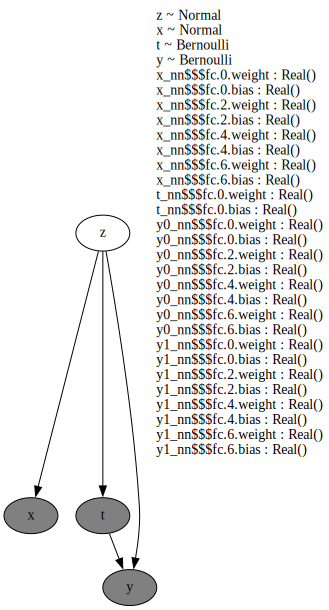

In [6]:
config = dict(
        feature_dim=feature_dim,
        latent_dim=latent_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_samples=num_samples,
        outcome_dist=outcome_dist
    )

pyro.render_model(ProxyConfounderModel(config), model_args=(x,t,y), render_distributions=True, render_params=True)

### Fit with SVI (to practice SVI syntax)

In [7]:
def observational_model(individual_model: ProxyConfounderModel) -> Callable:
    def _wrapper(x_obs, t_obs, y_obs):
        size = x_obs.shape[0]
        with pyro.plate("observations", size=size, dim=-1):
            return individual_model(x_obs, t_obs, y_obs)
    return _wrapper

model_to_fit = observational_model(ProxyConfounderModel(config))
guide = pyro.infer.autoguide.AutoNormal(model_to_fit)


# Define loss and optimize
# loss_fn = torch.nn.MSELoss(reduction='sum')
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model_to_fit, guide, adam, loss=Trace_ELBO())


num_iterations = 500 
x_data = x.clone().detach().requires_grad_(True)
t_data = t.clone().detach().requires_grad_(True)
y_data = y.clone().detach().requires_grad_(True)


pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, t_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))


# # Inspect learned parameters
# print("Learned parameters:")
# for name, param in model_to_fit.named_parameters():
#     print(name, param.data.numpy())

[iteration 0001] loss: 134.6248
[iteration 0101] loss: 36.2104
[iteration 0201] loss: 35.4132
[iteration 0301] loss: 35.2210
[iteration 0401] loss: 35.1679


## Query: conditional average treatment effect (CATE)

We can now set up a larger model in which the *conditional average
treatment effect* (CATE) we want to estimate is a random variable.

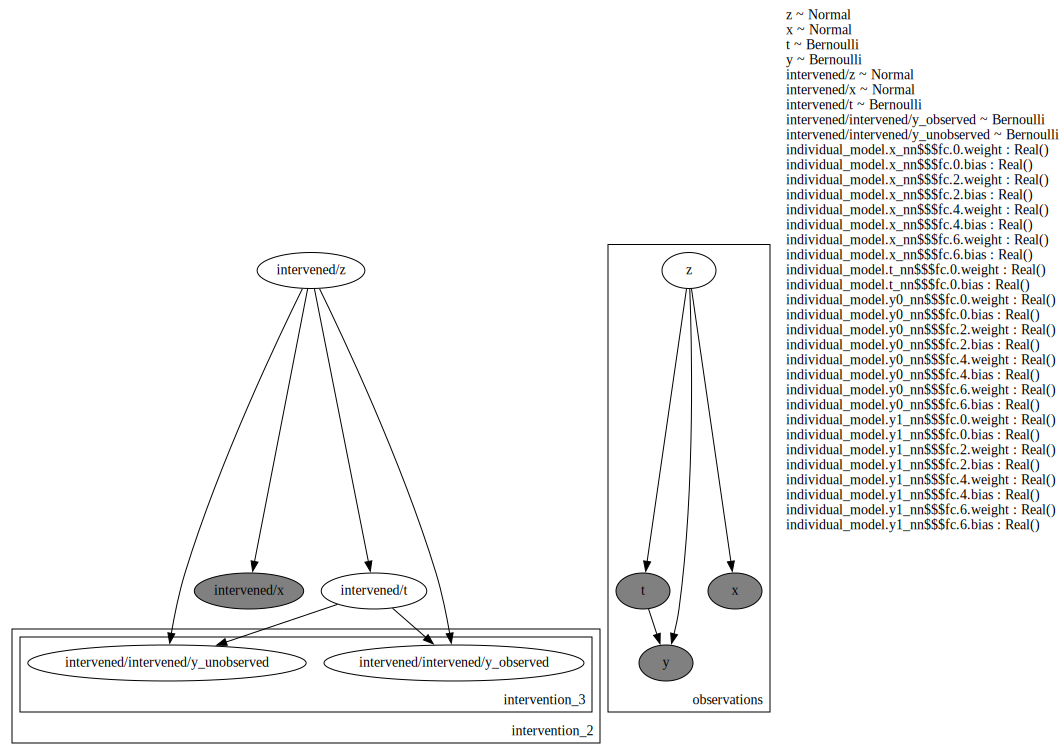

In [10]:
#                 scope(prefix="intervened"), \

class CEVAE_CATE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs, x_pred):

        with condition(data={"x": x_obs, "t": t_obs, "y": y_obs}), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):

            Y_obs = self.individual_model(x_obs)

        with MultiWorldCounterfactual(-2), \
                scope(prefix="intervened"), \
                do(actions={"intervened/t": 1. }), \
                do(actions={"intervened/t": 0. }), \
                condition(data={"x": x_pred}):
            Ys_pred = self.individual_model(x_pred)
#         CATE = Ys_pred[...,0,1,:] - Ys_pred[...,1,0,:]
#         CATE = pyro.deterministic("CATE", CATE) # see intro tutorial, makes it show up in traces
        return Ys_pred
    
pyro.render_model(CEVAE_CATE(ProxyConfounderModel(config)), model_args=(x,t,y,x), render_distributions=True, render_params=True)

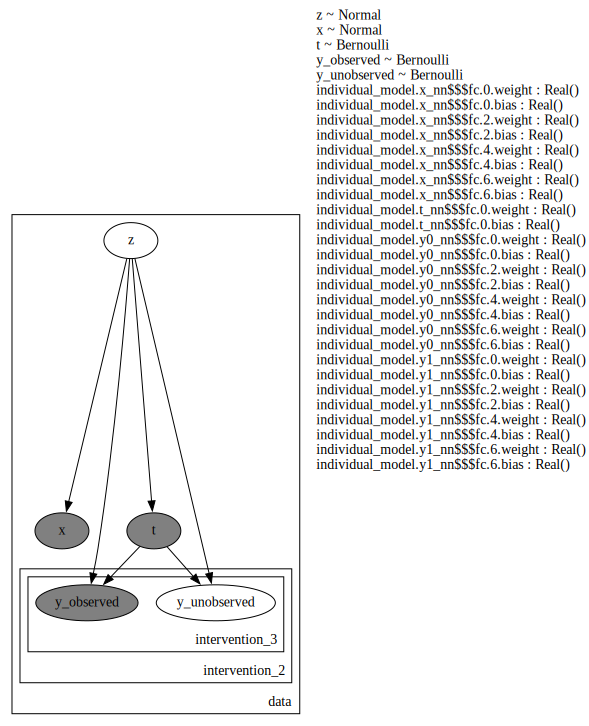

In [23]:
# Structure trying to match Sam's model:
class CEVAE_CATE_sam_style(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs, x_pred):
        extended_model = do(actions = {"t": 0})(
                            do(actions = {"t": 1})(
                                pyro.plate("data", size=x_obs.shape[0], dim=-1)(
                                    condition(data={"x": x_pred})(self.individual_model))))
        with MultiWorldCounterfactual(-2):
            Ys_pred = extended_model(x_obs, t_obs, y_obs)
        return Ys_pred
    
pyro.render_model(CEVAE_CATE_sam_style(ProxyConfounderModel(config)), model_args=(x,t,y,x), render_distributions=True, render_params=True)

# code from Sam: 
# def forward(self, covariates_obs, training_obs, earnings_obs, n=None):
#         if not covariates_obs is None:
#             # Little hack to allow sampling without observations
#             n = covariates_obs.shape[0]
#         elif not training_obs is None:
#             n = training_obs.shape[0]
#         elif not earnings_obs is None:
#             n = earnings_obs.shape[0]
#         extended_model = do(actions={"training": 0})(
#                             do(actions={"training": 1})(
#                                 pyro.plate("data", n, dim=-1)(
#                                         condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs})(
#                                                 backdoor_cbn))))
#         with MultiWorldCounterfactual(-2):
#             model_args = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)
#             _, _, earnings = extended_model(*model_args)
#         earnings_treatment = earnings[..., 1, 0, :]
#         earnings_control = earnings[..., 0, 1, :]
#         return pyro.deterministic("SATE", torch.sum(earnings_treatment - earnings_control, dim=-1) / n)_

In [ ]:
CEVAE_CATE(ProxyConfounderModel(config))(x,y,t,x)
model_tr = pyro.poutine.trace(model_to_fit).get_trace(x,y,t,x)
model_tr.nodes

# getting a sample, after SVI
# guide_tr = trace(guide).get_trace(covariates_obs, training_obs, earnings_obs, n=n)
# model_tr = trace(replay(model, trace=guide_tr)).get_trace(covariates_obs, training_obs, earnings_obs, n=n)
# Use predictive to sample: https://docs.pyro.ai/en/stable/inference_algos.html?highlight=Predictive#pyro.infer.predictive.Predictive

In [ ]:
# def forward(self, covariates_obs, training_obs, earnings_obs, n=None):

#         if not covariates_obs is None:
#             # Little hack to allow sampling without observations
#             n = covariates_obs.shape[0]
#         elif not training_obs is None:
#             n = training_obs.shape[0]
#         elif not earnings_obs is None:
#             n = earnings_obs.shape[0]

#         extended_model = do(actions={"training": 0})(
#                             do(actions={"training": 1})(


In [ ]:
model_to_fit = CEVAE_CATE(ProxyConfounderModel(config))
guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(model_to_fit, hide=['intervened/t', 'intervened/intervened/y_observed', 'intervened/intervened/y_unobserved']))


# Define loss and optimize
# loss_fn = torch.nn.MSELoss(reduction='sum')
adam = pyro.optim.Adam({"lr": 0.03})
elbo = TraceEnum_ELBO()
elbo.loss(model_to_fit, config_enumerate(guide, "parallel"), x,t,y,x);
svi = SVI(model_to_fit, guide, adam, loss=elbo)


num_iterations = 500 
x_data = x.clone().detach().requires_grad_(True)
t_data = t.clone().detach().requires_grad_(True)
y_data = y.clone().detach().requires_grad_(True)
x_pred_data = x.clone().detach().requires_grad_(True)


pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, t_data, y_data, x_pred_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))
        
        
# # fit the model
# num_epochs=100
# batch_size=100
# learning_rate=1e-3
# learning_rate_decay=0.1
# weight_decay=1e-4
# log_every=100


# dataset = TensorDataset(x, t, y)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# num_steps = num_epochs * len(dataloader)
# optim = ClippedAdam(
#             {
#                 "lr": learning_rate,
#                 "weight_decay": weight_decay,
#                 "lrd": learning_rate_decay ** (1 / num_steps),
#             }
#         )
# model = CEVAE_CATE(ProxyConfounderModel(config))
# guide = pyro.infer.autoguide.guides.AutoMultivariateNormal(model)

# svi = SVI(model_to_fit, guide, adam, loss=Trace_ELBO())

# num_iterations = 500 
# x_data = x.clone().detach().requires_grad_(True)
# t_data = t.clone().detach().requires_grad_(True)
# y_data = y.clone().detach().requires_grad_(True)


# pyro.clear_param_store()
# for j in range(num_iterations):
#     # calculate the loss and take a gradient step
#     loss = svi.step(x_data, t_data, y_data, x_data)
#     if j % 100 == 0:
#         print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))



In [ ]:
# for name, value in pyro.get_param_store().items():
#     print(name, pyro.param(name).data.cpu().numpy())
# guide(y,x)

The CATE is the expected return value of this new model, conditioning on
the observed covariates $X$. Any inference method available in Pyro
could be used to estimate it, including amortized variational inference
[@kingma2013auto] as in the original paper [@louizos2017causal].

## Below, copied from http://pyro.ai/examples/cevae.html, 
More docs here: https://docs.pyro.ai/en/latest/contrib.cevae.html

In [ ]:
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

"""
This example demonstrates how to use the Causal Effect Variational Autoencoder
[1] implemented in pyro.contrib.cevae.CEVAE, documented at
http://docs.pyro.ai/en/latest/contrib.cevae.html

**References**

[1] C. Louizos, U. Shalit, J. Mooij, D. Sontag, R. Zemel, M. Welling (2017).
    Causal Effect Inference with Deep Latent-Variable Models.
    http://papers.nips.cc/paper/7223-causal-effect-inference-with-deep-latent-variable-models.pdf
    https://github.com/AMLab-Amsterdam/CEVAE
"""
import argparse
import logging

import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.cevae import CEVAE

# logging.getLogger("pyro").setLevel(logging.DEBUG)
# logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)


def generate_data(num_data = 1000,
    feature_dim = 5):
    """
    This implements the generative process of [1], but using larger feature and
    latent spaces ([1] assumes ``feature_dim=1`` and ``latent_dim=5``).
    """
    z = dist.Bernoulli(0.5).sample([num_data])
    x = dist.Normal(z, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()
    y = dist.Bernoulli(logits=3 * (z + 2 * (2 * t - 2))).sample()

    # Compute true ite for evaluation (via Monte Carlo approximation).
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=3 * (z + 2 * (2 * t0_t1 - 2))).mean
    true_ite = y_t1 - y_t0
    return x, t, y, true_ite


def main(num_data = 1000,
    feature_dim = 5,
    num_layers = 3, 
    num_epochs = 50, 
    batch_size = 100, 
    learning_rate = 1e-3, 
    learning_rate_decay = 0.1, 
    weight_decay = 1e-4, 
    seed = 1234567890, 
    jit = False, 
    cuda = False,
    latent_dim = 20, 
    hidden_dim = 200):
    if cuda:
        torch.set_default_tensor_type("torch.cuda.FloatTensor")

    # Generate synthetic data.
    pyro.set_rng_seed(seed)
    x_train, t_train, y_train, _ = generate_data(num_data, feature_dim)

    # Train.
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=feature_dim,
        latent_dim=latent_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_samples=10,
    )
    cevae.fit(
        x_train,
        t_train,
        y_train,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        learning_rate_decay=learning_rate_decay,
        weight_decay=weight_decay,
    )

    # Evaluate.
    x_test, t_test, y_test, true_ite = generate_data(num_data, feature_dim)
    true_ate = true_ite.mean()
    print("true ATE = {:0.3g}".format(true_ate.item()))
    naive_ate = y_test[t_test == 1].mean() - y_test[t_test == 0].mean()
    print("naive ATE = {:0.3g}".format(naive_ate))
    if jit:
        cevae = cevae.to_script_module()
    est_ite = cevae.ite(x_test)
    est_ate = est_ite.mean()
    print("estimated ATE = {:0.3g}".format(est_ate.item()))
    return cevae


In [ ]:
cavae = main()

In [ ]:
cavae